### Simple Perceptron
A perceptron in a linear binary classifier inspired by the simplest unit of a biological neural network, the single-cell neuron. A brief discussion of the neuronal system will add context useful in understanding its artificial counterpart.

Membrane potential describes the charge interior to the cell membrane with respect to the environment exterior. In a neuron at rest, this is equal to approximatley -70 mV (millivolts). Chemical activity at the synapse between the cell and its neighbor can trigger depolarization, an event in which the polarization of the membrane is reduced; the membrane potential thus transiently increases towards a neutral value of 0 mV. 

If the stimulating event is of sufficient magnitude, the potential will reach, and then cross, a value of -55 mV. This value is significant and known as the **threshold potential**, or threshold above which cellular behavior changes. At ≥ 55 mV, an action potential, or 'spike' in membrane potential, is triggered. This consists of a rapid increase and equally rapid decrease as measured over time. All of this occurs on a scale of about 5 ms. 

< insert graphic of action potential >

< possibly explain voltage-gated sodium channels and g-proteins > 

Okay. So what does this mean for us? Much as a biological neuron requires reception of an input of sufficient magnitude to fire, a perceptron is activated only if its own threshold is met. Inputs are received and computations are performed upon them. The final result is a signal highly analogous to the electrochemical impulse passed between cells. 

## Setup
We'll start by importing dependencies. 

In [30]:
import random, math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data
We'll begin by importing our dataset. Please note that this algorithm is only suitable for linearly separable data sets, wherein a line could completely separate two classes in a binary classification problem. 

We'll be using the famous Iris set from the University of California, Irvine Machine Learning Repository. You can find it here: http://archive.ics.uci.edu/ml/datasets/Iris

Please note also that feature names are not specified in the data file; they are however listed on the set's page on the UCI site (link above). I will manually add these as column headers in the code below. 

In [31]:
df = pd.read_csv('Data/iris.data', 
                 names = ['Sepal Length (cm)',
                          'Sepal Width (cm)',
                          'Petal Length (cm)',
                          'Petal Width (cm)',
                          'Class'])

df.head() # Displays first five rows for us to inspect. 

,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Data exploration is key to any data science project. We'll make a few plots to better understand what we are working with. 

<AxesSubplot:title={'center':'Title'}, xlabel='Petal Length (cm)', ylabel='Petal Width (cm)'>

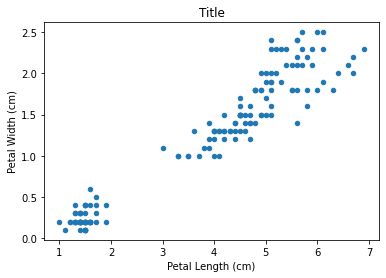

In [39]:
fig, ax = plt.subplots(facecolor = 'white')
df.plot.scatter(x = 'Petal Length (cm)',
                y = 'Petal Width (cm)',
                ax = ax, 
                title = 'Title')

In [33]:
class Perceptron:
    def __init__(self, num_inputs, c):
        self.weights = np.array([])
        self.c = c
        for i in range(0, num_inputs): # initialize random weights
            self.weights = np.append(self.weights, random.uniform(-1,1))
            
    def get_weights(self):
        '''
        Getter method to return weights. 

        Returns
        -------
        Numpy array
            self.weights

        '''
        return self.weights

    def train(self, inputs, label):
        '''
        Train the classifier

        Returns
        -------
        None

        '''
        guess = self.feedforward(inputs)
        error = label - guess
        for i in range(0, len(self.weights)):
            self.weights[i] += self.c * error * inputs[i]

    def feedforward(self, inputs):
        '''
        Perform feedforward calculations.
        
        Parameters
        ----------
        inputs : list
            Input data. 

        Returns
        -------
        TYPE
            self.activate(summation): activated weighted sum of inputs

        '''
        summation = 0
        for i in range(0, (len(self.weights))):
            x_i = inputs[i]
            w_i = self.weights[i]
            summation += np.dot(w_i, x_i)
        return self.activate(summation)

    def activate(self, total):
        '''
        Activation using a step function; binary output will be 0 or 1.

        Parameters
        ----------
        total : float
            The sum of the linear combination of inputs and weights.

        Returns
        -------
        int
            A value of 0 if sum is greater than or equal to zero;
            a value of 1 if sum is less than zero.
        '''        
        if total >= 0:
            return 1
        if total < 0:
            return 0
